## LAB 5 - TASK 4-OPTIONAL submission. ML 2024-25.


FILL UP THIS BOX WITH YOUR DETAILS

**NAME AND NIP**: 

- Ignacio Pastore Benaim, 920576
- David Padilla Orenga, 946874

# Network Visualization

This notebook is based on the materials from the Stanford Course CS231n: Convolutional Neural Networks for Visual Recognition, by Fei-Fei Li et al.

**GOAL: to explore the use of *image gradients* for generating new images.**

When training a model, we define a loss function which measures our current unhappiness with the model's performance; we then use backpropagation to compute the gradient of the loss with respect to the model parameters, and perform gradient descent on the model parameters to minimize the loss.

Here we will start from a convolutional neural network model which has been trained to perform image classification. We will quantify the current unhappiness with a given image and compute and analyze the gradient of the loss with respect to the pixels of the image. For all of the following, note we keep **the model fixed** and just **update our image** in some cases.

We will explore two techniques for image generation:
1. **Saliency Maps**: Saliency maps are a quick way to tell which part of the image influenced the classification decision made by the network.
2. **Fooling Images**: We can perturb an input image so that it appears the same to humans, but will be misclassified by the pretrained network.



## 0. Set up
Some set up for the required files, etc ...

In [ ]:
you_want_to_use_gdrive = False
if you_want_to_use_gdrive:
    # IF YOU WANT TO USE YOUR GOOGLE DRIVE (recommended)
    # this mounts your Google Drive to the Colab VM.
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    # enter the foldername in your Drive where you have saved the auxiliary files for this lab
    FOLDERNAME = 'lab5/'
    assert FOLDERNAME is not None, "[!] Enter the foldername."

    # now that we've mounted your Drive, this ensures that
    # the Python interpreter of the Colab VM can load
    # python files from within it.
    import sys
    sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

In [ ]:
# IF YOU WANT TO UPLOAD THE FILES TO THE CURRENT SESSION ONLY
#!unzip lab5_files.zip

# in any case, YOU NEED TO MAKE SURE you have accessible (here or in your drive)
# the auxiliary files for this task:

#folder dataset with
#imagenet_val_25.npz
#img1.jpg
#img2.jpg
# python files data_utils.py image_utils.py

In [ ]:
import sys
sys.path.append('../')
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from data_utils import load_tiny_imagenet
from image_utils import preprocess_image, deprocess_image
from image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## 1. Load pretrained CNN Model for Image Classification

For all these experiments we start from a CNN pretrained for image classification on ImageNet dataset.

We could use any model, but in this example we use the network used in Lab3, MobileNetV2. **You can use either the original model (as code in this example) or load the fine-tuned model you obtained in Lab3 for your toy-dataset**

In [ ]:
SAVE_PATH = 'datasets/'
# Colab
#SAVE_PATH = '/content/drive/My Drive/{}/{}'.format(FOLDERNAME, 'datasets/')

# to match mobileNet sizes
img_width = 224
img_height = 224
IMG_SHAPE = (img_width, img_height) + (3,)

model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                            include_top=True,
                                            weights='imagenet')

model.trainable = False

## 2. Load some (ImageNet) images
The file imagenet_val_25.npz contains a few example images from the validation set of the ImageNet ILSVRC 2012 Classification dataset.

Run the following cell to visualize some of these images, along with their ground-truth labels.


In [ ]:
from data_utils import load_imagenet_val
import cv2

X_raw, y, class_names = load_imagenet_val(num=5)

# If you want to load your own images you could un-comment the following code
## you can overwrite the initial X_raw OR initialize from scratch,
## for example to 10 empty images and then fill up with yours
## X_raw = np.zeros( (10,224,224,3), dtype=np.uint8)
#img1 = plt.imread("img1.jpeg")
#img2 = plt.imread("img2.jpeg")

# if they are far from squared, maybe better do some cropping?
#img1_224 = cv2.resize(img1, (224, 224))
#img2_224 = cv2.resize(img2, (224, 224))

# X_raw[0] = img1_224
# X_raw[1] = img2_224
# you would need to put the label "number" that corresponds to your classifier outputs
# ImageNet class labels are in class_names
# y[0] = 281 # label for tabby cat
# y[1] = 208 # label for labrador

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_raw[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

In [ ]:
# to find possible labels from ImageNet to your images (if you use the default model instead of your own, where you do know the actual label)
# print(class_names)

**Preprocess images.** The input to the pretrained model is expected to be normalized, so we first preprocess the images by subtracting the pixelwise mean and dividing by the pixelwise standard deviation.

In [ ]:
X = np.array([preprocess_image(img) for img in X_raw])

## 3. Get the Saliency Maps
We will compute class saliency maps as described in Section 3.1 of [2].

A **saliency map** tells us the degree to which each pixel in the image affects the classification score for that image. To compute it, we compute the gradient of the unnormalized score corresponding to the correct class (which is a scalar) with respect to the pixels of the image. If the image has shape `(H, W, 3)` then this gradient will also have shape `(H, W, 3)`; for each pixel in the image, this gradient tells us the amount by which the classification score will change if the pixel changes by a small amount. To compute the saliency map, we take the absolute value of this gradient, then take the maximum value over the 3 input channels; the final saliency map thus has shape `(H, W)` and all entries are nonnegative.


[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.


### **TO-DO LAB4**:

* Run the following code to visualize some class saliency maps on the example images from the ImageNet validation set using the default MobileNet model loaded.

* Re-run for your fine-tuned model from Lab3 (modify the code above) and show the saliency map for one image from each of your toy-data-set classes.

1. **If you want to get the full grade for this exercise, you need to use your own MobileNet finetuned model** and visualize here some of your own images (some of the test set you used when fine-tuning your model). The code gives you some helper code to replace imageNet images with your own. **Careful with label** assigned to each image. ImageNet assigns labels from 0 to 999 according to the label-names defined in *class_names*. For your fine-tuned model, it'll be from 0 to N, make sure you know which number corresponds to which of your classes.

2. **If you don't have yet your fine-tuned model**, get the saliency maps for 5 images from your toy-dataset using the label that current MobileNetV2 model assigns to those images when you try to classify them with it.

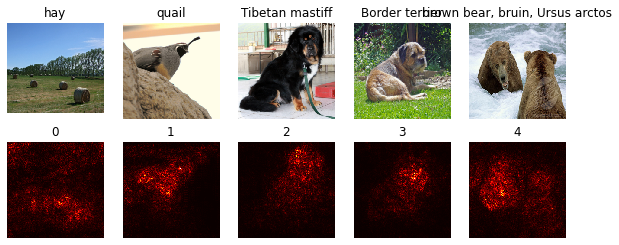

In [ ]:
def compute_and_show_saliency_maps(X, y, mask):
    mask = np.asarray(mask)
    Xm = X[mask]
    ym = y[mask]

    ############################################################################
    # To produce the saliency maps over a batch of images.                     #
    #                                                                          #
    # 1) Define a gradient tape object and watch input Image variable          #
    # 2) Compute the loss for the batch of given input images.                 #
    #    - get scores output by the model for the given batch of input images  #
    #    - use tf.gather_nd or tf.gather to get correct scores                 #
    # 3) Use the gradient() method of the gradient tape object to compute the  #
    #    gradient of the loss with respect to the image                        #
    # 4) Finally, process the returned gradient to compute the saliency map.   #
    ############################################################################

    with tf.GradientTape() as g:
        image = tf.Variable(Xm)
        g.watch(image)
        scores = model(image)
        loss = tf.gather_nd(scores, tf.stack((tf.range(X.shape[0]), ym), axis=1))
        dimage = g.gradient(loss, image)
        saliency = np.abs(dimage).max(axis=3)


    for i in range(mask.size):
        plt.subplot(2, mask.size, i + 1)
        plt.imshow(deprocess_image(Xm[i]))
        plt.axis('off')
        plt.title(class_names[ym[i]])
        plt.subplot(2, mask.size, mask.size + i + 1)
        plt.title(mask[i])
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(10, 4)
    plt.show()



mask = np.arange(5)
compute_and_show_saliency_maps(X, y, mask)

## 4. Generating Fooling Images
We can also use image gradients to generate "fooling images" as discussed in [3]. Given an image and a target class, we can perform gradient **ascent** over the image to maximize the target class, stopping when the network classifies the image as the target class. Implement the following function to generate fooling images.

[3] Szegedy et al, "Intriguing properties of neural networks", ICLR 2014

### **TO-DO LAB4**:

* FILL UP THE REQUIRED GAPS (marked as TO-BE-FILLED)

* Run the code to generate a fooling image. You should ideally see at first glance no major difference between the original and fooling images, but the network should now make an incorrect prediction on the fooling one. However you should see a bit of random noise if you look at the 10x magnified difference between the original and fooling images. Feel free to change the `idx` variable to explore other images.

* Get and visualize 5 different fooling image examples

In [ ]:
def get_and_visualize_fooling_image(Xi, target_y):
    # Make a copy of the input that we will modify
    X_fooling = Xi.copy()

    # Step size for the update
    learning_rate = 1

    ##############################################################################
    # Generate a fooling image X_fooling that the model will classify as         #
    # the class target_y. Use gradient ***** !!!ASCENT!!! *****
    # on the target class score, using                                           #
    # the model.scores Tensor to get the class scores for the model.image.       #
    # When computing an update step, first normalize the gradient:               #
    #   dX = learning_rate * g / ||g||_2                                         #
    #                                                                            #
    # In the training loop, each iteration makes an update to the input image    #
    # X_fooling (don't modify Xi!). The loop should stop when the predicted clas #
    # for the input is the same as target_y.                                     #
    #                                                                            #
    # tf.GradientTape() keeps track of your gradients and                        #
    # tape.gradient gets the actual gradient with respect to X_fooling           #
    #                                                                            #
    # For most examples, you should be able to generate a fooling image          #
    # in fewer than 100 iterations of gradient ascent.                           #
    ##############################################################################

    for i in range(100):
        X_fooling = tf.Variable(X_fooling)

        with tf.GradientTape() as g:
            scores = model(X_fooling)

            #### TO-DO-LAB4 ####
            # as the loss, we will use the score of the new class we want to maximize
            loss = 0
            # loss = TO-BE-FILLED

            # calculate gradients
            dfooling = g.gradient(loss, X_fooling)

            #### TO-DO-LAB4 ####
            # gradient ascent: in this case we want to maximize! (the score of the "new" class)
            # TO-BE-FILLED - What's the correct option here from the following 3?
            X_fooling = X_fooling
            #X_fooling = X_fooling + learning_rate * dfooling/tf.norm(dfooling,ord=2)
            #X_fooling = X_fooling - learning_rate * dfooling/tf.norm(dfooling,ord=2)
            #X_fooling = learning_rate * dfooling/tf.norm(dfooling,ord=2)


            #### TO-DO-LAB4 ####
            # what do we need to check in the current scores
            # to see if our new image has already fooled the network?
            max_score_label = 0
            #max_score_label = TO-BE-FILLED
            print("it %d - loss %lf - predicted %d - target %d" % (i, loss, max_score_label, target_y) )
            if max_score_label == target_y:
                break



    # Make sure that X_fooling is classified as y_target
    scores = model(X_fooling)
    assert tf.math.argmax(scores[0]).numpy() == target_y, 'The network is not fooled!'

    # Show original image, fooling image, and difference
    orig_img = deprocess_image(Xi[0])
    fool_img = deprocess_image(X_fooling[0])
    plt.figure(figsize=(12, 6))

    # Rescale
    plt.subplot(1, 4, 1)
    plt.imshow(orig_img)
    plt.axis('off')
    plt.title(class_names[y[idx]])
    plt.subplot(1, 4, 2)
    plt.imshow(fool_img)
    plt.title(class_names[target_y])
    plt.axis('off')
    plt.subplot(1, 4, 3)
    plt.title('Difference')
    plt.imshow(deprocess_image((Xi-X_fooling)[0]))
    plt.axis('off')
    plt.subplot(1, 4, 4)
    plt.title('Magnified difference (10x)')
    plt.imshow(deprocess_image(10 * (Xi-X_fooling)[0]))
    plt.axis('off')
    plt.gcf().tight_layout()



idx = 0
Xi = X[idx][None]
target_y = 6
get_and_visualize_fooling_image(Xi, target_y)

In [ ]:
# TO-DO LAB4: get and visualize 5 different fooling examples you have run
